In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as shapiro
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')

In [54]:
df=pd.read_csv(r"C:\Users\Mojisola_susan\Downloads\cookie_cats.csv")
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


##  Data Exploration

In [55]:
df.shape

(90189, 5)

In [56]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [57]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [58]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


In [59]:
df_filtered=df[df['sum_gamerounds']>0]

In [60]:
#checking for Outliers

sum_gamerounds    Axes(0.125,0.11;0.775x0.77)
dtype: object

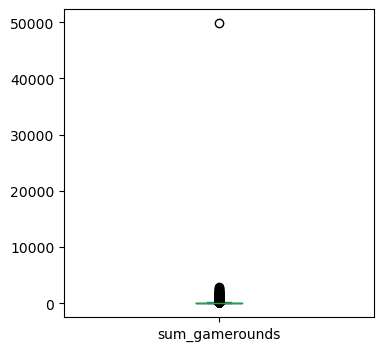

In [61]:
df_filtered['sum_gamerounds'].plot(
    kind='box',
    figsize=(4,4),
    subplots=True
)

In [62]:
#Removing Outliers with interquatile range

(62288, 5)


sum_gamerounds    Axes(0.125,0.11;0.775x0.77)
dtype: object

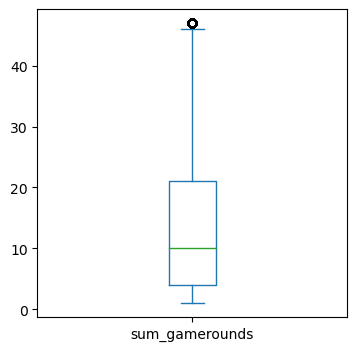

In [63]:
upper_limit = (df_filtered.sum_gamerounds.quantile(0.75) - df_filtered.sum_gamerounds.quantile(0.25))

data = df_filtered[df['sum_gamerounds'] < upper_limit]
print(data.shape)

data['sum_gamerounds'].plot(
    kind = 'box',
    figsize = (4,4),
    subplots = True
)

In [64]:
df_filtered['sum_gamerounds'].describe()

count    86195.00000
mean        54.27606
std        199.19155
min          1.00000
25%          6.00000
50%         18.00000
75%         54.00000
max      49854.00000
Name: sum_gamerounds, dtype: float64

In [45]:
pd.DataFrame({"RET1_COUNT": data["retention_1"].value_counts(),
              "RET7_COUNT": data["retention_7"].value_counts(),
              "RET1_RATIO": data["retention_1"].value_counts() / len(data),
              "RET7_RATIO": data["retention_7"].value_counts() / len(data)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,42565,58348,0.683358,0.936745
True,19723,3940,0.316642,0.063255


In [65]:
## checking for statistical significance diffrence
print("For Retention_1:")
data.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

For Retention_1:


count  median       mean        std  max
version retention_1                                          
gate_30 False        21095     6.0  10.352595  10.357636   47
        True          9960    22.0  23.100703  12.617588   47
gate_40 False        21470     6.0   9.957056   9.899444   47
        True          9763    21.0  22.301342  12.505035   47

In [66]:
print("For Retention_7:")
data.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

For Retention_7:


count  median       mean        std  max
version retention_7                                          
gate_30 False        28985     9.0  13.609074  12.181778   47
        True          2070    26.0  26.092754  12.928068   47
gate_40 False        29363     9.0  13.117222  11.814462   47
        True          1870    24.0  24.783422  12.992266   47

## AB Testing

Check normality
If Normal Distribution, check homogeneity

Steps:

Split & Define Control Group & Test Group.
Apply Shapiro Test for normality.
If parametric apply Levene Test for homogeneity of variances.
If Parametric + homogeneity of variances apply T-Test.
If Parametric - homogeneity of variances apply Welch Test.
If Non-parametric apply Mann Whitney U Test directly.

In [67]:
#define into groups
data["group"] = np.where(data.version == "gate_30", "group_one", "group_two")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7,group
0,116,gate_30,3,False,False,group_one
1,337,gate_30,38,True,False,group_one
3,483,gate_40,1,False,False,group_two
7,1444,gate_40,2,False,False,group_two
10,1842,gate_40,3,False,True,group_two


<Axes: ylabel='Frequency'>

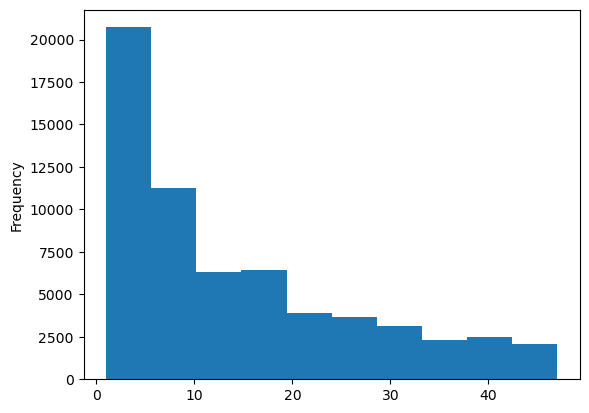

In [68]:
data['sum_gamerounds'].plot(kind='hist')

In [69]:
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "group_one"][target]
    groupB = dataframe[dataframe[group] == "group_two"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
            
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
    
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=data, group = "group", target = "sum_gamerounds")


# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,1.757023e-07,A/B groups are not similar!


## Conclusion

For our dataset,
Mann Whitney U Testing rejected H0 hypothesis and we learned A/B groups are not similar!

Firstly, we investigated relationships and structures in the data. There was no missing value problem but was one outlier problem in the data. Summary stats and plots help us to understand the data and problem.

Before A/B Testing, we shared some details about game, players, and problems associatied.
After applying A/B Testing, the analysis result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing rejected H0 hypothesis and we learned A/B groups are not similar!

Briefly, There are statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.

 Which level has more advantages in terms of player retention?
1-day and 7-day average retention are higher when the gate is at level 30 than when it is at level 40.